# House Price Prediction - Advanced Regression Techniques

# Introduction
Explanation of this Jupyter notebook.

## Table of Contents
- [Data collection & initial exploration](#Data-collection-&-initial-exploration)
  - [Setup and imports](#setup-and-imports)
  - [Initial exploration](#initial-exploration)
- [Feature engineering](#feature-engineering)
  - [Preprocessing](#preprocessing)
    - [Data Cleaning](#Data-cleaning)
      - [Identify columns with missing values](#identify-columns-with-missing-values)
      - [Drop columns](#drop-columns)
      - [Impute missing values](#impute-missing-values)
  - [Concatenation](#Concatenation)
  - [Encoding](#Encoding)
  - [Split](#split)
- [Model Building](#Model-Building)
  - [Model 1 - Linear regression](#Model-1---Linear-regression)
    - [First try linear regression & performance](#first-try-linear-regression-&-performance)
    - [Enhancement of linear regression](#enhancement-of-linear-regression)
  - [Model 2 - Random forest](#Model-2---Random-forest)
    - [First try random forest & performance](#first-try-random-forest-&-performance)
    - [Enhancement of random forest](#enhancement-of-random-forest)
  - [Model 3 - XGBoost](#Model-3---XGBoost)
    - [First try XGBoost & performance](#first-try-xgboost-&-performance)
    - [Enhancement of XGBoost](#enhancement-of-xgboost)
- [Conclusion & submission](#conclusion-&-submission)



# Data collection & initial exploration

## Setup and imports

In [1195]:
#Import relevant packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
from sklearn.preprocessing import OneHotEncoder

In [1196]:
#Read in data
train_df = pd.read_csv("train.csv")
# set seed for reproducibility
np.random.seed(0)

#Delete ID column
train_df.drop(['Id'], axis=1, inplace=True)

We drop the ID column to make sure this feature does not affect the prediction. 

## Initial exploration

In [1197]:
#Show first five rows of dataframe. This gives us an initial overview over what we are dealing with. 
train_df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1198]:
train_df.shape

(1460, 80)

In [1199]:
train_df.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object

Initial exploration shows us that the training dataset consists of 1460 rows, and 80 columns. The final column includes the target feature: sale price. The dataset contains various datatypes like int64, float64 and object. We will handle this later under "encoding". 

In [1200]:
# find categorical variables
categorical = [var for var in train_df.columns if train_df[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))

There are 43 categorical variables


In [1201]:
# find numerical variables
numerical = [var for var in train_df.columns if train_df[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 37 numerical variables


We  will assume that variables with a definite and low number of unique values are discrete.

In [1202]:
# let's visualise the values of the discrete variables
discrete = []
for var in numerical:
    if len(train_df[var].unique())<20:
        print(var, ' values: ', train_df[var].unique())
        discrete.append(var)

MSSubClass  values:  [ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]
OverallQual  values:  [ 7  6  8  5  9  4 10  3  1  2]
OverallCond  values:  [5 8 6 7 4 2 3 9 1]
BsmtFullBath  values:  [1 0 2 3]
BsmtHalfBath  values:  [0 1 2]
FullBath  values:  [2 1 3 0]
HalfBath  values:  [1 0 2]
BedroomAbvGr  values:  [3 4 1 2 0 5 6 8]
KitchenAbvGr  values:  [1 2 3 0]
TotRmsAbvGrd  values:  [ 8  6  7  9  5 11  4 10 12  3  2 14]
Fireplaces  values:  [0 1 2 3]
GarageCars  values:  [2 3 1 0 4]
PoolArea  values:  [  0 512 648 576 555 480 519 738]
MoSold  values:  [ 2  5  9 12 10  8 11  4  1  7  3  6]
YrSold  values:  [2008 2007 2006 2009 2010]


In [1203]:
# first we make a list of continuous variables (from the numerical ones)
continuous = [var for var in numerical if var not in discrete and var not in ['Id', 'SalePrice']]
continuous

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'MiscVal']

# Feature engineering

## Preprocessing

### Data cleaning

#### Identify columns with missing values
The first cleaning of data we are going to do is handle columns with missing data points.

In [1204]:
#Get the number of missing data points per column
missing_values_count = train_df.isnull().sum()
#Get columns with at least one missing data point
columns_with_missing_data = missing_values_count[missing_values_count > 0]

print(columns_with_missing_data)

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


#### Drop columns
We will drop columns which are missing more than 80% of their values.
<font color='red'>Should find a source which recommends percentage of missingness to drop a column.</font> 

In [1205]:
#Create list of columns which miss more values than 80%.
columns_to_drop = missing_values_count[missing_values_count > 0.8*1460].index

train_df.drop(columns=columns_to_drop, inplace=True)
train_df.shape

(1460, 76)

Can now see that the four columns "Alley", "PoolQC", "Fence" and "MiscFeature" have been removed. 

#### Impute missing values
For the rest of the columns with missing values we will impute values. For the numeric columns we will impute the mean of the values in the column, and for the categorical columns we will impute the mode. 

In [1206]:
# Numeric
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(train_df['LotFrontage'].mean())
train_df['MasVnrArea'] = train_df['MasVnrArea'].fillna(train_df['MasVnrArea'].mean())
train_df['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(train_df['GarageYrBlt'].mean())

# Categorical
train_df['MasVnrType'] = train_df['MasVnrType'].fillna(train_df['MasVnrType'].mode()[0])
train_df['BsmtQual'] = train_df['BsmtQual'].fillna(train_df['BsmtQual'].mode()[0])
train_df['BsmtCond'] = train_df['BsmtCond'].fillna(train_df['BsmtCond'].mode()[0])
train_df['BsmtExposure'] = train_df['BsmtExposure'].fillna(train_df['BsmtExposure'].mode()[0])
train_df['BsmtFinType1'] = train_df['BsmtFinType1'].fillna(train_df['BsmtFinType1'].mode()[0])
train_df['BsmtFinType2'] = train_df['BsmtFinType2'].fillna(train_df['BsmtFinType2'].mode()[0])
train_df['Electrical'] = train_df['Electrical'].fillna(train_df['Electrical'].mode()[0])
train_df['FireplaceQu'] = train_df['FireplaceQu'].fillna(train_df['FireplaceQu'].mode()[0])
train_df['GarageType'] = train_df['GarageType'].fillna(train_df['GarageType'].mode()[0])
train_df['GarageFinish'] = train_df['GarageFinish'].fillna(train_df['GarageFinish'].mode()[0])
train_df['GarageQual'] = train_df['GarageQual'].fillna(train_df['GarageQual'].mode()[0])
train_df['GarageCond'] = train_df['GarageCond'].fillna(train_df['GarageCond'].mode()[0])

# Check that we have no missing datapoints.
missing_values_count = train_df.isnull().sum()
columns_with_missing_data = missing_values_count[missing_values_count > 0]
print(columns_with_missing_data)

Series([], dtype: int64)


### Handling outliers

#### Outliers in continous variables

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


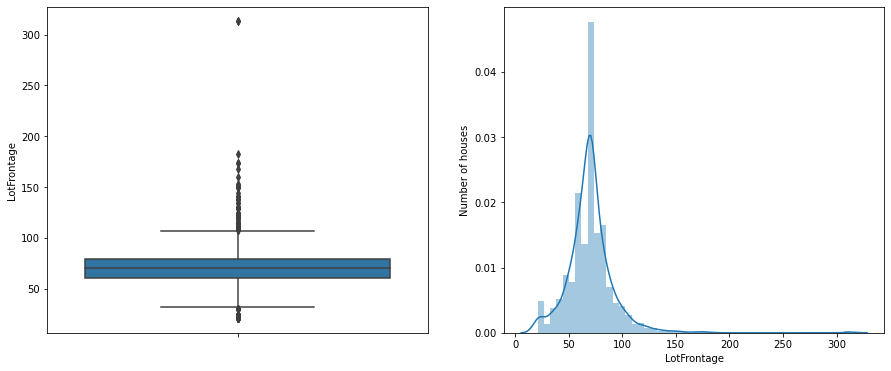

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


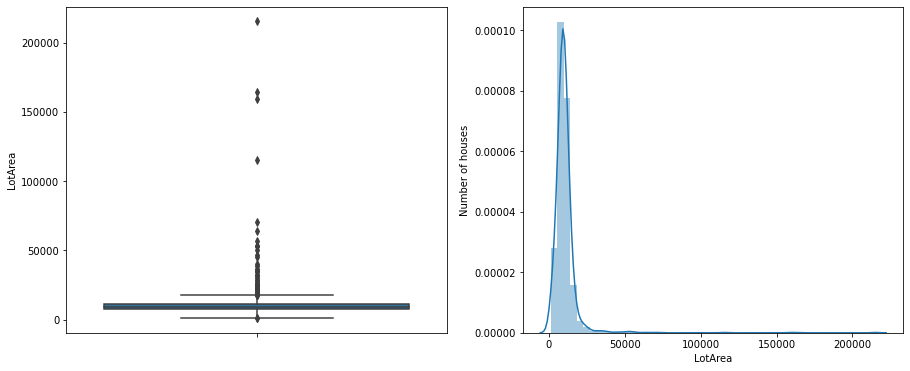

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


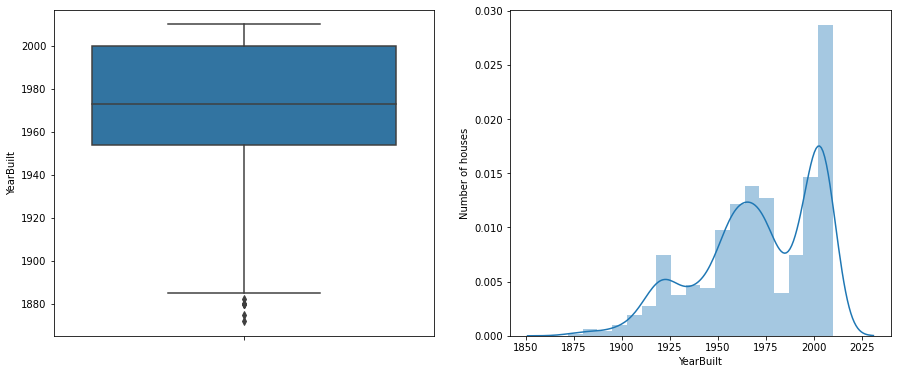

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


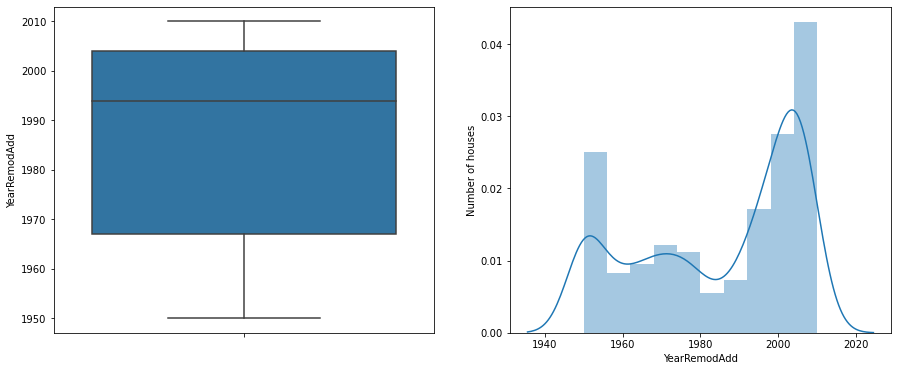

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


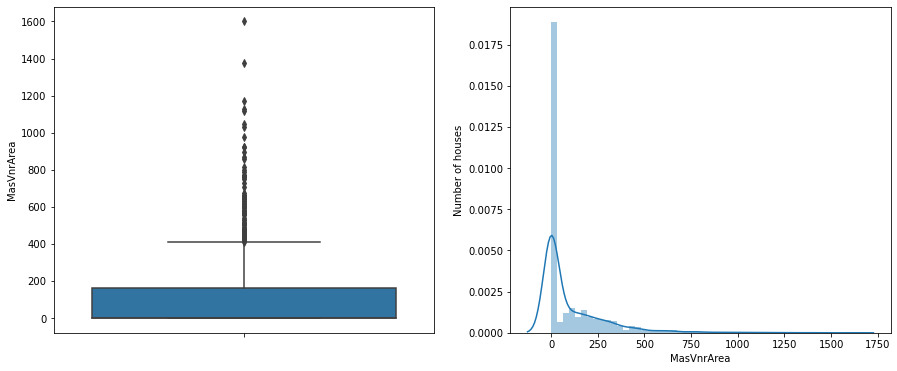

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


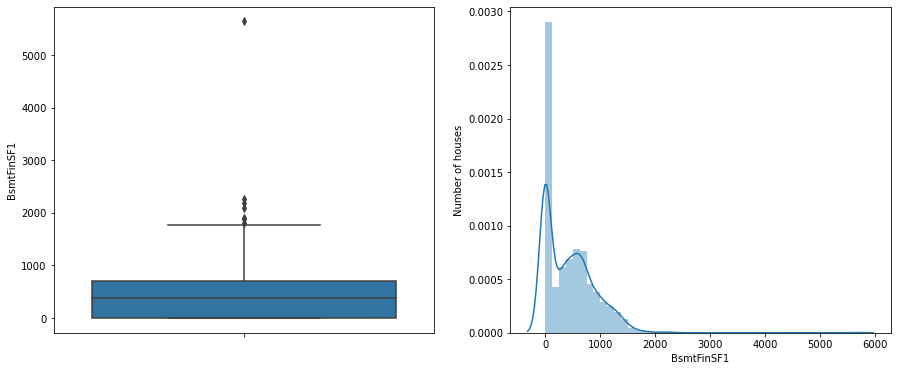

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


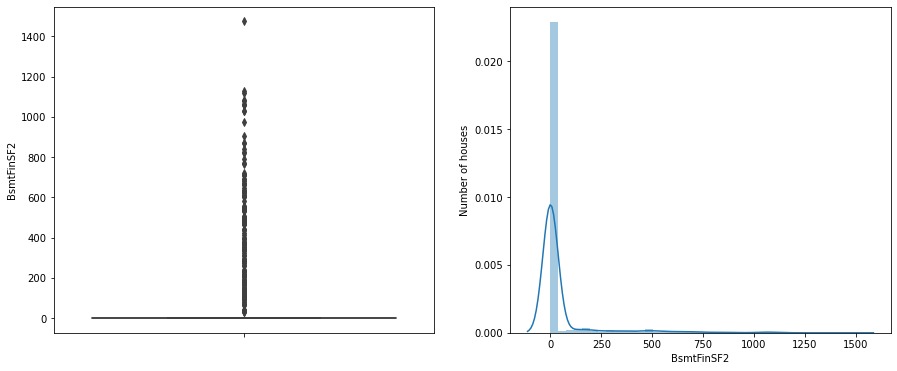

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


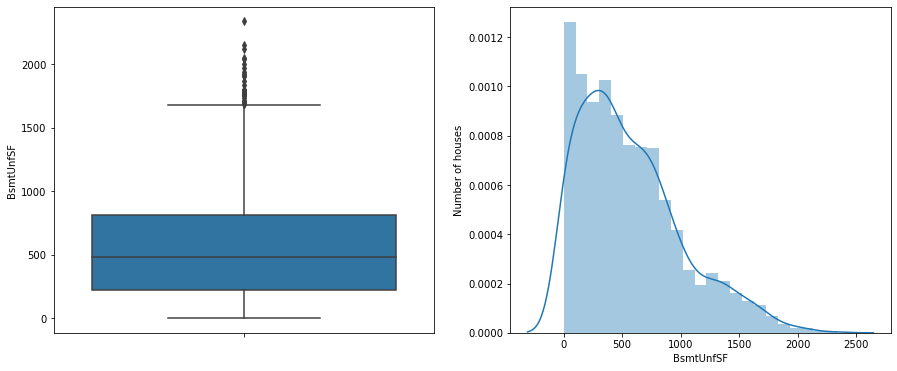

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


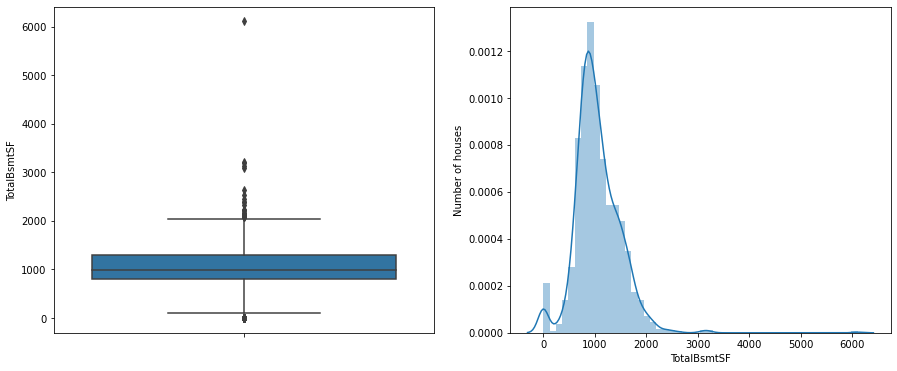

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


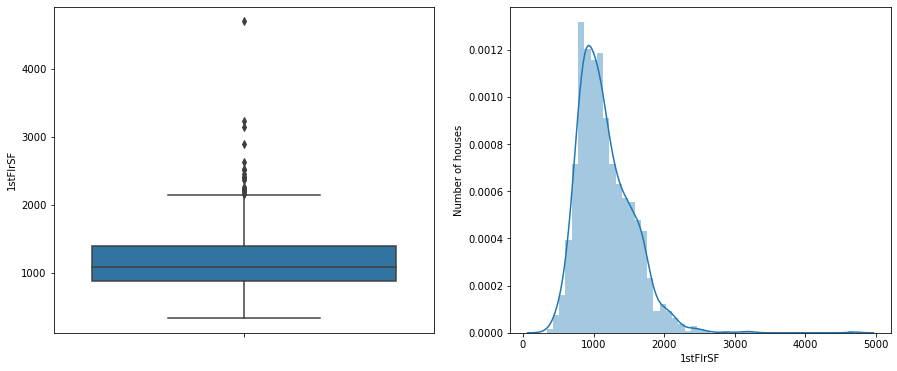

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


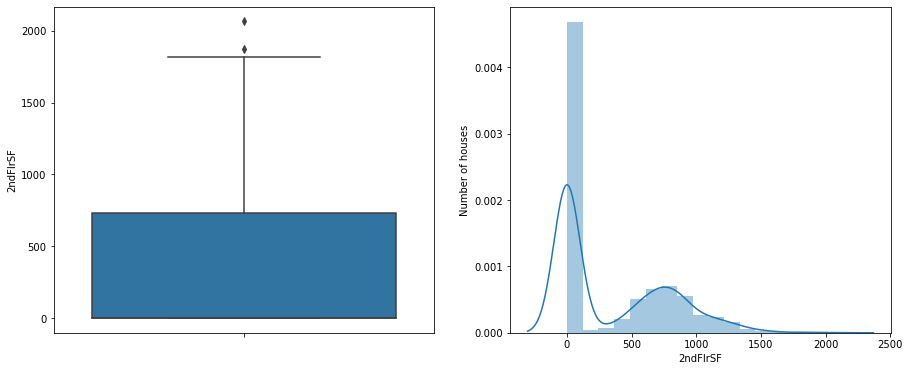

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


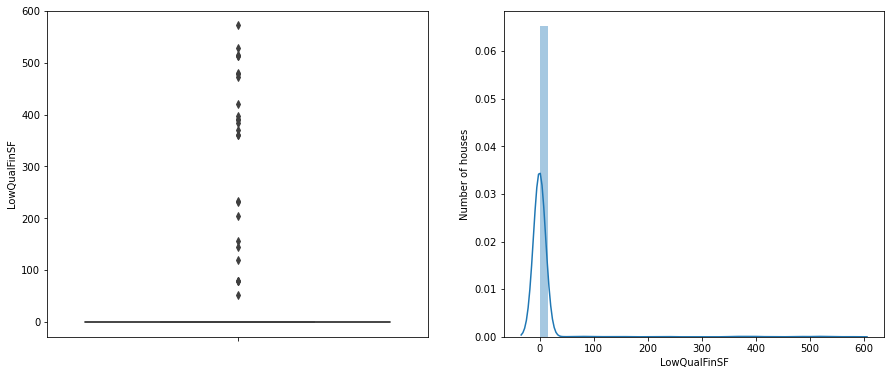

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


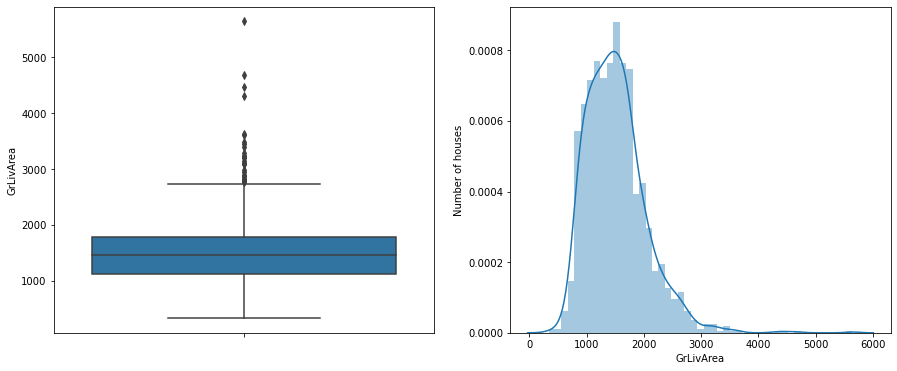

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


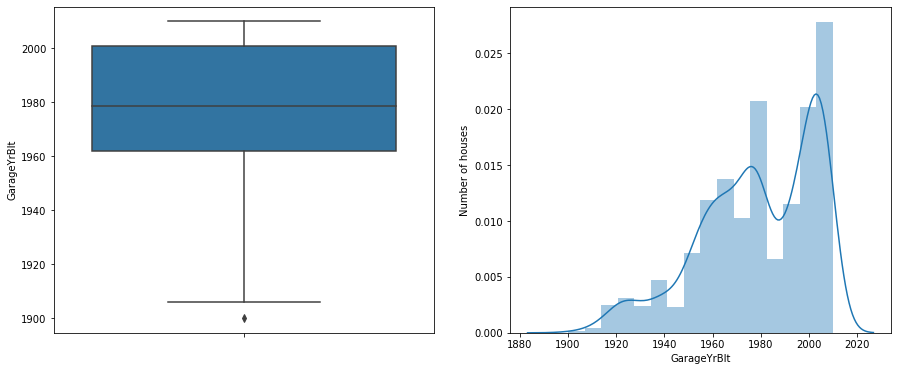

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


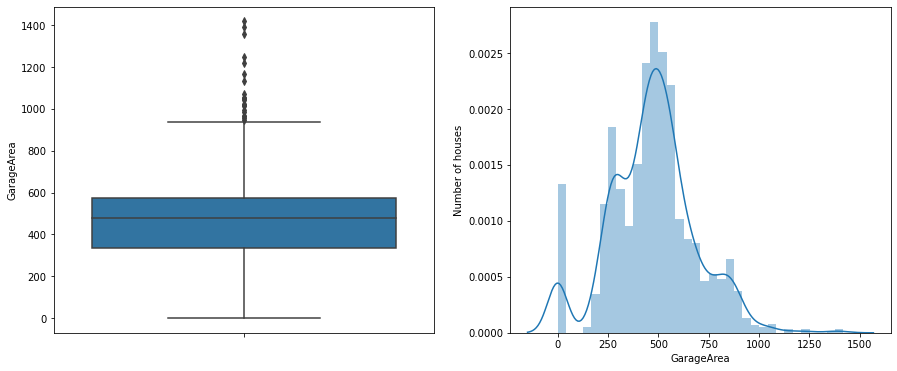

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


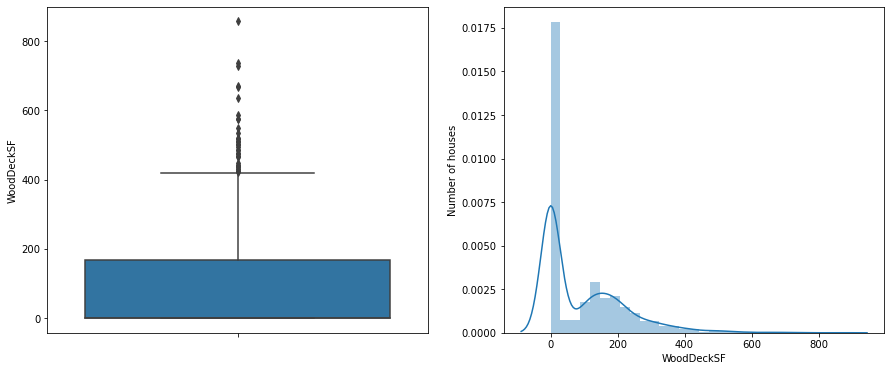

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


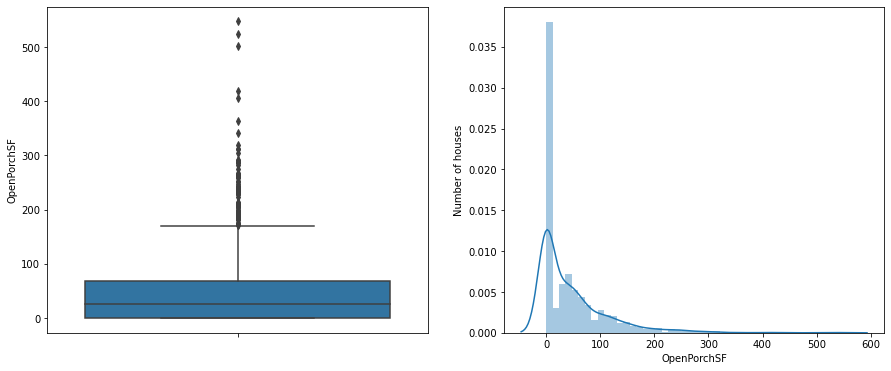

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


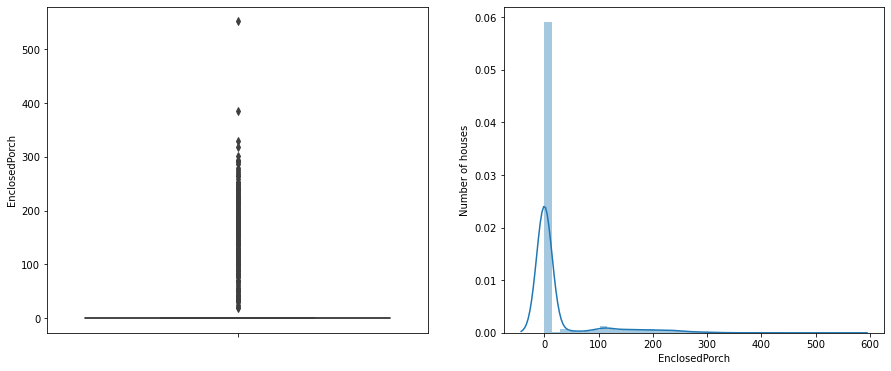

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


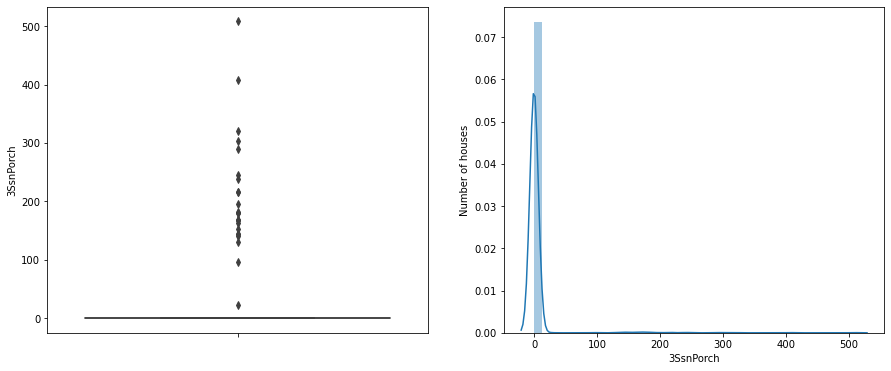

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


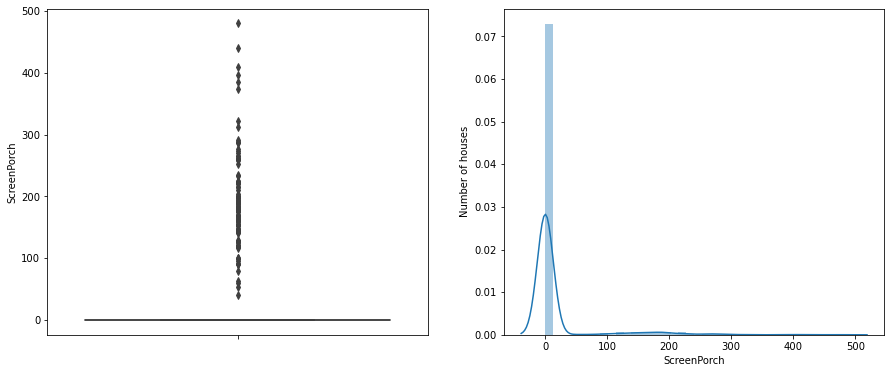

/Users/frederickpretlove/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


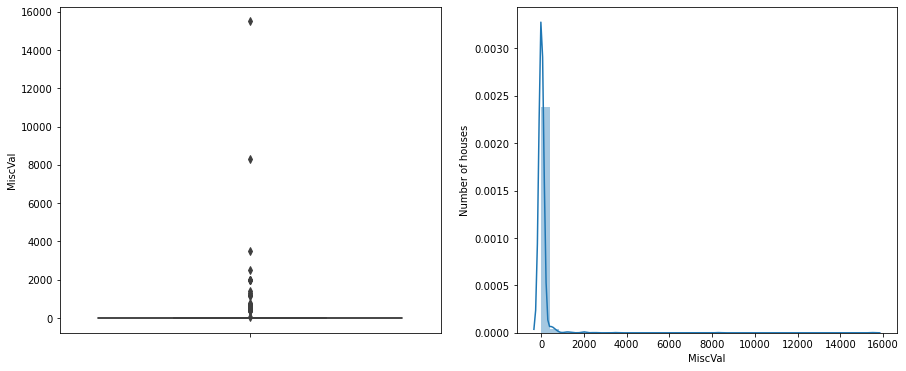

In [1207]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution

for var in continuous:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = sns.boxplot(y=train_df[var])
    fig.set_title('')
    fig.set_ylabel(var)
    
    plt.subplot(1, 2, 2)
    fig = sns.distplot(train_df[var].dropna())
    fig.set_ylabel('Number of houses')
    fig.set_xlabel(var)

    plt.show()

As most variables are skewed, we will transform them with the box cox transformation. 

In [1208]:


# # for variable transformation
# import scipy.stats as stats
# def boxcox_transformation(var):
#     train_df[var], param = stats.boxcox(train_df[var]+1)
    
# for var in continuous:
#     boxcox_transformation(var)

In [1209]:
# for var in transformed_continous:
#     plt.figure(figsize=(15,6))
#     plt.subplot(1, 2, 1)
#     fig = sns.boxplot(y=train_df[var])
#     fig.set_title('')
#     fig.set_ylabel(var)
    
#     plt.subplot(1, 2, 2)
#     fig = sns.distplot(train_df[var].dropna())
#     fig.set_ylabel('Number of houses')
#     fig.set_xlabel(var)

#     plt.show()

In [1210]:
#Qualitative assessment of which features have outliers.
outlier_columns = ['BsmtFinSF2', '1stFlrSF','GrLivArea', '3SsnPorch', 'ScreenPorch', 'MiscVal']


for column in outlier_columns:
    # Calculate quartiles
    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    # Filter the DataFrame to exclude outliers
    train_df = train_df[(train_df[column] >= lower_bound) & (train_df[column] <= upper_bound)]

In [1211]:
train_df.shape

(1102, 76)

#### Outliers in discrete variables

In [1212]:
# outlies in discrete variables
# for var in discrete:
#     print(train_df[var].value_counts() / np.float(len(train_df)))
#     print()
    
for var in discrete:
    value_counts = train_df[var].value_counts() / len(train_df)
    categories_to_remove = value_counts[value_counts < 0.01].index
    train_df = train_df[~train_df[var].isin(categories_to_remove)] 

In [1213]:
train_df.shape

(1010, 76)

## Concatenation 
In this part we are going to concatenate the training data with the test data, to encode the whole dataset. 

In [1214]:
test_df = pd.read_csv('processed_test_df')
train_test_df = pd.concat([train_df,test_df],axis=0)

In [1215]:
train_test_df.shape

(2469, 76)

## Encoding
To use our models we have to encode the categorical columns in our dataset. To do this we will use the sklearns One hot encoder.

<font color='red'>Need to address the columns that are categorical but represented by numbers.</font>

In [1216]:
#Find categorical columns represented by numbers
numerical_columns = train_df.select_dtypes('int64','float64')

print(numerical_columns.nunique())

#Checking these values with the data description. The categorical values represented numerically are:
#MSSubClass, OverallQual, OverallCond, 

#Unsure about: BsmtFullBath, BsmtHalfBath

MSSubClass        12
LotArea          776
OverallQual        7
OverallCond        7
YearBuilt        104
YearRemodAdd      61
BsmtFinSF1       430
BsmtFinSF2         1
BsmtUnfSF        632
TotalBsmtSF      549
1stFlrSF         574
2ndFlrSF         311
LowQualFinSF      10
GrLivArea        643
BsmtFullBath       2
BsmtHalfBath       2
FullBath           3
HalfBath           2
BedroomAbvGr       4
KitchenAbvGr       2
TotRmsAbvGrd       7
Fireplaces         3
GarageCars         4
GarageArea       363
WoodDeckSF       200
OpenPorchSF      162
EnclosedPorch     94
3SsnPorch          1
ScreenPorch        1
PoolArea           1
MiscVal            1
MoSold            12
YrSold             5
SalePrice        528
dtype: int64


In [1217]:
# Identify categorical columns
categorical_columns = train_test_df.select_dtypes(include=['object']).columns

# Preprocess the data to ensure categorical columns contain only strings
train_test_df[categorical_columns] = train_test_df[categorical_columns].astype(str)

# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')

# Fit and transform the categorical data using one-hot encoding
X_encoded = encoder.fit_transform(train_test_df[categorical_columns])

# Get the feature names
feature_names = encoder.get_feature_names_out(input_features=categorical_columns)

# Create a DataFrame with the one-hot encoded features
X_encoded_train_test_df = pd.DataFrame(X_encoded, columns=feature_names)

# Reset the index of both DataFrames
X_encoded_train_test_df.reset_index(drop=True, inplace=True)
train_test_df.reset_index(drop=True, inplace=True)

# Combine the one-hot encoded features with the original numerical features
train_test_df = pd.concat([X_encoded_train_test_df, train_test_df.drop(categorical_columns, axis=1)], axis=1)

## Split
Now we will split the train and test set so we can train a regression model, and then use this model to predict the test-data.

In [1218]:
# nan_mask = train_df['SalePrice'].isna()

nan_mask = train_test_df['SalePrice'].isna()

# Use diff() to find the transition from non-NaN to NaN
transition_mask = nan_mask.diff() == True

# Find the index of the first occurrence of the transition
border_index = transition_mask.idxmax()

print(border_index)

HPP_data_Train = train_test_df.iloc[:border_index,:]
HPP_data_Test = train_test_df.iloc[border_index:,:]

#Dropping SalePrice in test-data. This is the value we are going to predict.
HPP_data_Test.drop(['SalePrice'],axis=1,inplace=True)

1010


/var/folders/3q/1zyht42n1v9767scrnt3hmcc0000gn/T/ipykernel_41690/3621637436.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HPP_data_Test.drop(['SalePrice'],axis=1,inplace=True)


# Model building

## Model 1 - Linear regression

### First try linear regression & performance

Root Mean Squared Error: 17873.996937108084


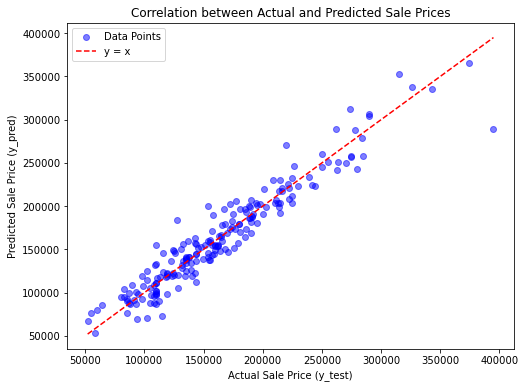

In [1219]:
# Import the necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# X_train contains features, and y_train contains the target variable (SalePrice).
X_train= HPP_data_Train.drop(['SalePrice'],axis=1)
y_train= HPP_data_Train['SalePrice']

#Below we split the training data into train and test, so that we have labels for the actual Sale price.
#This is used to analyze our model to further enhance it. 

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#Initialize the linear regression model
linear_regression_model = LinearRegression()

# Fit the liner_regression_model to the training data
linear_regression_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = linear_regression_model.predict(X_test)

# Calculate the Mean Squared Error (MSE) to evaluate the liner_regression_model's performance
mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE) by taking the square root of MSE
import math
rmse = math.sqrt(mse)

# Print the RMSE
print("Root Mean Squared Error:", rmse)



# Create a scatter plot to visualize the correlation
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue', alpha=0.5, label='Data Points')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='y = x')
plt.xlabel("Actual Sale Price (y_test)")
plt.ylabel("Predicted Sale Price (y_pred)")
plt.title("Correlation between Actual and Predicted Sale Prices")
plt.legend()
plt.show()

### Enhancement of linear regression
<font color='red'>Copy in feature engineering from H and T</font>

In [1220]:
#these are not just continous. these are all the numerical columns
continuous_column = train_df.select_dtypes(include=[np.number]).columns.tolist()

# for i in continuous_column:
#     plt.figure(figsize=(10,5))
#     sns.boxplot(data=train_df,y=i)
#     plt.title(f" Box plot for {i}")
#     plt.ylabel(i)
#     plt.show()

In [1221]:
for column in continuous_column:
    # Calculate quartiles
    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define lower and upper bounds
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)

    # Filter the DataFrame to exclude outliers
    train_df = train_df[(train_df[column] >= lower_bound) & (train_df[column] <= upper_bound)]


## Model 2 - Random forest

### First try random forest & performance

Root Mean Squared Error: 28057.726049287507


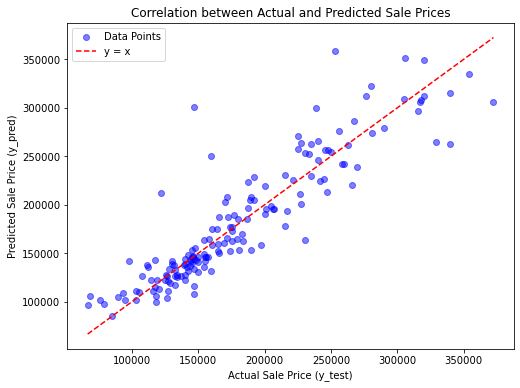

In [1222]:
# Import the necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# X_train should contain your features, and y_train should contain the target variable (SalePrice).
X_train = HPP_data_Train.drop(['SalePrice'], axis=1)
y_train = HPP_data_Train['SalePrice']

# Initialize the RandomForestRegressor model
random_forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)  # You can adjust the number of estimators as needed

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Fit the model to the training data
random_forest_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = random_forest_regressor.predict(X_test)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Fit the random_forest_regressor to the training data
random_forest_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = random_forest_regressor.predict(X_test)

# Calculate the Mean Squared Error (MSE) to evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)

# Calculate the Root Mean Squared Error (RMSE) by taking the square root of MSE
import math
rmse = math.sqrt(mse)

# Print the RMSE
print("Root Mean Squared Error:", rmse)




# Create a scatter plot to visualize the correlation
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue', alpha=0.5, label='Data Points')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='y = x')
plt.xlabel("Actual Sale Price (y_test)")
plt.ylabel("Predicted Sale Price (y_pred)")
plt.title("Correlation between Actual and Predicted Sale Prices")
plt.legend()
plt.show()

### Enhancement of random forest

## Model 3 - XGBoost

### First try XGBoost & performance

### Enhancement of XGBoost

# Conclusion & submission

In [1223]:
#TODO here we need to do the actual prediction of the test set (and training of the model) with our chosen model (based on highest performance).

In [1224]:
pred=pd.DataFrame(y_pred)
# Create a DataFrame with 'Id' values (1461 to N+1460) and the 'SalePrice' values from 'pred'
pred['Id'] = range(1461, 1461 + len(pred))
pred = pred.rename(columns={0: 'SalePrice'})
# Create a new DataFrame with columns named "Id" and "SalePrice"
result_df = pred[['Id', 'SalePrice']]
# Save the DataFrame to a CSV file
result_df.to_csv('predicted_saleprice.csv', index=False)